100%|██████████| 170M/170M [00:10<00:00, 16.4MB/s] 


Displaying 5 random samples from the training set:


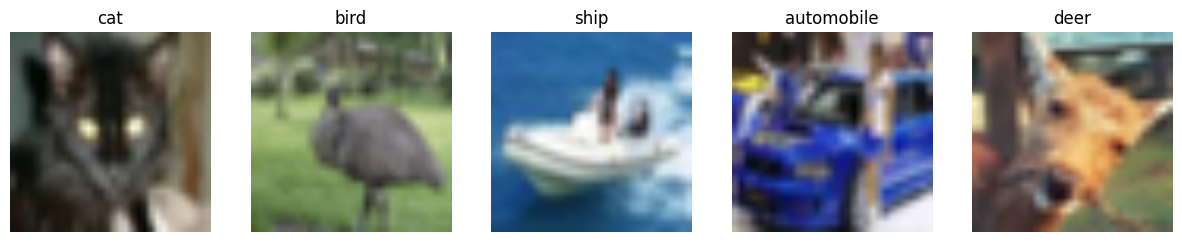

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler

torch.manual_seed(42)
np.random.seed(42)

#CLIP normalization parameters
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]

#training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=clip_mean, std=clip_std)  # Normalize with CLIP values
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])

#CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

#Split
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
train_size = int(0.8 * num_train)  # 80% for training, 20% for validation
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_dataset.transform = train_transform
test_dataset.transform = val_test_transform

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=val_test_transform)
val_dataset.data = train_dataset.data[val_indices]
val_dataset.targets = [train_dataset.targets[i] for i in val_indices]
train_dataset.data = train_dataset.data[train_indices]
train_dataset.targets = [train_dataset.targets[i] for i in train_indices]

#labels CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#5 random samples
def show_random_samples(dataset, num_samples=5):
    # Create a DataLoader to sample random images
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))
    

    denorm = transforms.Normalize(
        mean=[-m/s for m, s in zip(clip_mean, clip_std)],
        std=[1/s for s in clip_std]
    )
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = denorm(images[i]).permute(1, 2, 0).numpy()  # Convert to HWC format for display
        img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

print("Displaying 5 random samples from the training set:")
show_random_samples(train_dataset)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to(device)
clip_model.eval()  # Set CLIP to evaluation mode
print("CLIP model loaded and set to evaluation mode.")

#Load pre-trained ResNet-20
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
target_model = target_model.to(device)
target_model.eval()
print("ResNet-20 model loaded and set to evaluation mode.")

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
text_prompts = [f"a photo of a {cls}" for cls in classes]

text_inputs = clip_processor(text=text_prompts, return_tensors="pt", padding=True, truncation=True)
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
with torch.no_grad():
    text_embeddings = clip_model.get_text_features(**text_inputs)
print("Text embeddings for CIFAR-10 classes generated.")
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
print(f"Text embeddings shape: {text_embeddings.shape}")
torch.save(text_embeddings, "cifar10_text_embeddings.pt")
print("Text embeddings saved to 'cifar10_text_embeddings.pt'.")

2025-06-12 19:05:11.085995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749755111.253085      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749755111.316214      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP model loaded and set to evaluation mode.


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 38.5MB/s

ResNet-20 model loaded and set to evaluation mode.
Text embeddings for CIFAR-10 classes generated.
Text embeddings shape: torch.Size([10, 512])
Text embeddings saved to 'cifar10_text_embeddings.pt'.


In [1]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using device: cuda
CLIP model loaded and set to evaluation mode.


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


ResNet-20 model loaded and set to evaluation mode.
CLIP accuracy on clean images: 87.83%
CLIP accuracy on adversarial images (PGD attack on ResNet-20): 49.87%


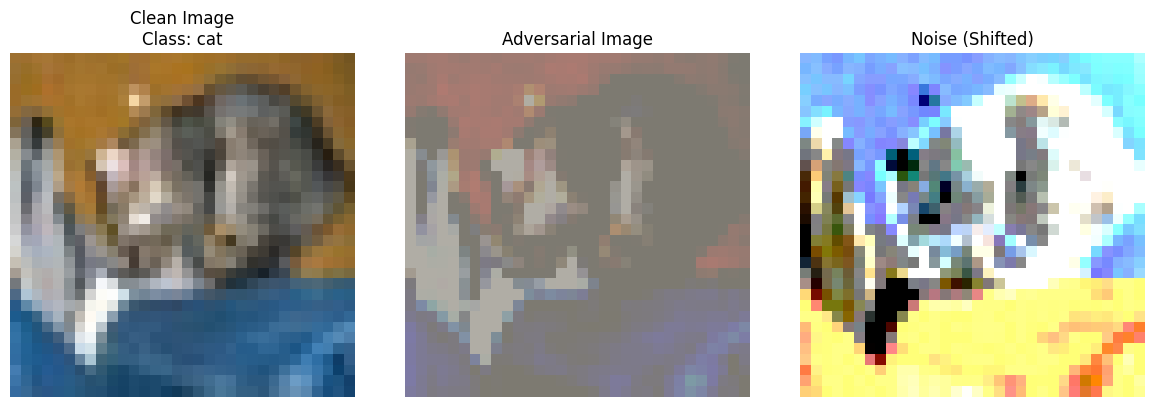

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to(device)
clip_model.eval()
print("CLIP model loaded and set to evaluation mode.")

target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
target_model = target_model.to(device)
target_model.eval()
print("ResNet-20 model loaded and set to evaluation mode.")

#CLIP transformations
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]
test_transform_clip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])
test_dataset_clip = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_clip)
test_loader_clip = DataLoader(test_dataset_clip, batch_size=32, shuffle=False)

test_transform_resnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
test_dataset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_resnet)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)
text_embeddings = torch.load("cifar10_text_embeddings.pt").to(device)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def evaluate_clip(model, loader, text_embeddings, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            image_features = model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_embeddings.t() * 100 
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

clean_accuracy = evaluate_clip(clip_model, test_loader_clip, text_embeddings, device)
print(f"CLIP accuracy on clean images: {clean_accuracy:.2f}%")

attack = torchattacks.PGD(target_model, eps=8/255, alpha=2/255, steps=7)
adversarial_images = []
true_labels = []
for images, labels in test_loader_resnet:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = attack(images, labels)
    adversarial_images.append(adv_images.cpu())
    true_labels.append(labels.cpu())
adversarial_images = torch.cat(adversarial_images)
true_labels = torch.cat(true_labels)

adv_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])
adv_images_transformed = torch.stack([adv_transform(img) for img in adversarial_images])
adv_dataset = torch.utils.data.TensorDataset(adv_images_transformed, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

#Evaluate
adv_accuracy = evaluate_clip(clip_model, adv_loader, text_embeddings, device)
print(f"CLIP accuracy on adversarial images (PGD attack on ResNet-20): {adv_accuracy:.2f}%")

#visualization
sample_idx = 0
clean_image, label = test_dataset_resnet[sample_idx]
adv_image = adversarial_images[sample_idx]
noise = adv_image - clean_image

denorm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])],
    std=[1/s for s in [0.2023, 0.1994, 0.2010]]
)
clean_image = denorm(clean_image).permute(1, 2, 0).numpy()
adv_image = denorm(adv_image).permute(1, 2, 0).numpy()
noise = noise.permute(1, 2, 0).numpy()
clean_image = np.clip(clean_image, 0, 1)
adv_image = np.clip(adv_image, 0, 1)
noise = np.clip(noise + 0.5, 0, 1)  # Shift noise for visibility

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(clean_image)
axes[0].set_title(f"Clean Image\nClass: {classes[label]}")
axes[0].axis('off')
axes[1].imshow(adv_image)
axes[1].set_title("Adversarial Image")
axes[1].axis('off')
axes[2].imshow(noise)
axes[2].set_title("Noise (Shifted)")
axes[2].axis('off')
plt.tight_layout()
plt.show()


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
#!pip install torchattacks
!pip install peft
import torchattacks

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to(device)
print("CLIP model loaded.")

# Load pre-trained ResNet-20 model
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
target_model = target_model.to(device)
target_model.eval()
print("ResNet-20 model loaded and set to evaluation mode.")

# Load CIFAR-10 test dataset with CLIP transformations
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]
test_transform_clip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])
test_dataset_clip = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_clip)
test_loader_clip = DataLoader(test_dataset_clip, batch_size=32, shuffle=False)

# Load CIFAR-10 test dataset for ResNet-20 (32x32, standard normalization)
test_transform_resnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
test_dataset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_resnet)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)

# Load precomputed text embeddings
text_embeddings = torch.load("cifar10_text_embeddings.pt").to(device)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Apply LoRA to CLIP's vision module
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # Target attention layers in vision transformer
    lora_dropout=0.1,
    bias="none",
    modules_to_save=None
)
clip_model = get_peft_model(clip_model, lora_config)
clip_model = clip_model.to(device)
clip_model.train()  # Set to training mode for fine-tuning
print("LoRA applied to CLIP vision module.")

# Generate adversarial training dataset (10,000 images)
attack = torchattacks.PGD(target_model, eps=8/255, alpha=2/255, steps=7)
adversarial_images = []
true_labels = []
for images, labels in test_loader_resnet:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = attack(images, labels)
    adversarial_images.append(adv_images.cpu())
    true_labels.append(labels.cpu())
adversarial_images = torch.cat(adversarial_images)[:10000]  # Limit to 10,000 samples
true_labels = torch.cat(true_labels)[:10000]

# Transform adversarial images for CLIP
adv_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])
adv_images_transformed = torch.stack([adv_transform(img) for img in adversarial_images])[:10000]
adv_dataset = TensorDataset(adv_images_transformed, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=True)

# Define optimizer for LoRA parameters
optimizer = torch.optim.AdamW(clip_model.parameters(), lr=1e-4)

# Fine-tune CLIP for one epoch on adversarial images
print("Starting adversarial fine-tuning with LoRA...")
clip_model.train()
for images, labels in adv_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    # Compute image embeddings
    image_features = clip_model.get_image_features(images)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    # Compute logits
    logits = image_features @ text_embeddings.t() * 100  # Scale for stability
    # Compute loss
    loss = torch.nn.CrossEntropyLoss()(logits, labels)
    # Backpropagate
    loss.backward()
    optimizer.step()
print(f"Fine-tuning completed. Final loss: {loss.item():.4f}")

# Function to evaluate CLIP (zero-shot classification)
def evaluate_clip(model, loader, text_embeddings, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            image_features = model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_embeddings.t() * 100
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

# Evaluate CLIP on clean test set after fine-tuning
clip_model.eval()
clean_accuracy = evaluate_clip(clip_model, test_loader_clip, text_embeddings, device)
print(f"CLIP accuracy on clean images after fine-tuning: {clean_accuracy:.2f}%")

# Generate new adversarial test set for evaluation
adversarial_images_test = []
true_labels_test = []
for images, labels in test_loader_resnet:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = attack(images, labels)
    adversarial_images_test.append(adv_images.cpu())
    true_labels_test.append(labels.cpu())
adversarial_images_test = torch.cat(adversarial_images_test)
true_labels_test = torch.cat(true_labels_test)

# Transform adversarial test images for CLIP
adv_images_test_transformed = torch.stack([adv_transform(img) for img in adversarial_images_test])
adv_test_dataset = TensorDataset(adv_images_test_transformed, true_labels_test)
adv_test_loader = DataLoader(adv_test_dataset, batch_size=32, shuffle=False)

# Evaluate CLIP on adversarial test set after fine-tuning
adv_accuracy = evaluate_clip(clip_model, adv_test_loader, text_embeddings, device)
print(f"CLIP accuracy on adversarial images after fine-tuning: {adv_accuracy:.2f}%")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda
CLIP model loaded.


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


ResNet-20 model loaded and set to evaluation mode.


100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s] 


LoRA applied to CLIP vision module.
Starting adversarial fine-tuning with LoRA...
Fine-tuning completed. Final loss: 0.5233
CLIP accuracy on clean images after fine-tuning: 92.52%
CLIP accuracy on adversarial images after fine-tuning: 86.66%


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import torchattacks
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn


torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to(device)
clip_model.eval()
print("CLIP model loaded and set to evaluation mode.")

#torchattacks
class CLIPWrapper(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
    
    def forward(self, x):
        return self.clip_model.get_image_features(x)

# Load CIFAR-10 datasets
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=clip_mean, std=clip_std)
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Subset training data to 10,000 samples
indices = np.random.choice(len(train_dataset), 10000, replace=False)
train_subset = Subset(train_dataset, indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load precomputed text embeddings
text_embeddings = torch.load("cifar10_text_embeddings.pt").to(device)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# TeCoA contrastive loss function
def contrastive_loss(image_features, text_features, labels, tau=0.07):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    logits = (image_features @ text_features.t()) / tau
    loss = F.cross_entropy(logits, labels)
    return loss

# PGD attack for contrastive loss
def pgd_attack(model, images, text_features, labels, eps=1/255, alpha=1/255, steps=2):
    images = images.clone().detach().requires_grad_(True)
    orig_images = images.clone().detach()
    
    for _ in range(steps):
        model.zero_grad()
        image_features = model.get_image_features(images)
        loss = contrastive_loss(image_features, text_features, labels)
        loss.backward()
        with torch.no_grad():
            adv_images = images + alpha * images.grad.sign()
            delta = torch.clamp(adv_images - orig_images, min=-eps, max=eps)
            images = torch.clamp(orig_images + delta, min=0, max=1).requires_grad_(True)
    return images

# Visual Prompt Tuning (VPT) module
class VisualPrompt(nn.Module):
    def __init__(self, prompt_size=5, embed_dim=768):  # Fixed to 768
        super().__init__()
        self.prompt = nn.Parameter(torch.randn(prompt_size, embed_dim))
    
    def forward(self, x):
        batch_size = x.size(0)
        prompt = self.prompt.unsqueeze(0).repeat(batch_size, 1, 1)
        return torch.cat([prompt, x], dim=1)


def evaluate_clip(model, loader, text_embeddings, device, vpt=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            if vpt is not None:
                image_features = model.vision_model(images).last_hidden_state
                image_features = vpt(image_features)
                image_features = model.vision_model.ln_post(image_features)
                image_features = image_features[:, 0, :]  # CLS token
            else:
                image_features = model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_embeddings.t() * 100
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

#TeCoA
def train_tecoa(model, train_loader, text_embeddings, device, epochs=10, vpt=None, finetune=False):
    if vpt is not None:
        optimizer = optim.SGD(vpt.parameters(), lr=40, momentum=0.9)
        print("Training with Visual Prompt Tuning")
    else:
        optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
        print("Training with Finetuning")
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            adv_images = pgd_attack(model, images, text_embeddings, labels)
            model.zero_grad()
            if vpt is not None:
                image_features = model.vision_model(adv_images).last_hidden_state
                image_features = vpt(image_features)
                image_features = model.vision_model.ln_post(image_features)
                image_features = image_features[:, 0, :]  # CLS token
            else:
                image_features = model.get_image_features(adv_images)
            loss = contrastive_loss(image_features, text_embeddings, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Train with Finetuning
print("Starting TeCoA Finetuning")
train_tecoa(clip_model, train_loader, text_embeddings, device, finetune=True)

# Evaluate on clean test set
clean_accuracy_ft = evaluate_clip(clip_model, test_loader, text_embeddings, device)
print(f"TeCoA Finetuning - Clean accuracy: {clean_accuracy_ft:.2f}%")

# Generate adversarial test images (100-step PGD)
clip_wrapper = CLIPWrapper(clip_model).to(device)
attack = torchattacks.PGD(clip_wrapper, eps=1/255, alpha=1/255, steps=100)
attack.set_device(device)  # Explicitly set device
adversarial_images = []
true_labels = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = attack(images, labels)
    adversarial_images.append(adv_images.cpu())
    true_labels.append(labels.cpu())
adversarial_images = torch.cat(adversarial_images)
true_labels = torch.cat(true_labels)

# Create adversarial dataset
adv_dataset = torch.utils.data.TensorDataset(adversarial_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

adv_accuracy_ft = evaluate_clip(clip_model, adv_loader, text_embeddings, device)
print(f"TeCoA Finetuning - Adversarial accuracy (100-step PGD): {adv_accuracy_ft:.2f}%")

# Train with Visual Prompt Tuning
print("\nStarting TeCoA Visual Prompt Tuning")
vpt = VisualPrompt(prompt_size=5, embed_dim=768).to(device)  # Fixed to 768
train_tecoa(clip_model, train_loader, text_embeddings, device, vpt=vpt, epochs=10)

# Evaluate with VPT
clean_accuracy_vpt = evaluate_clip(clip_model, test_loader, text_embeddings, device, vpt=vpt)
adv_accuracy_vpt = evaluate_clip(clip_model, adv_loader, text_embeddings, device, vpt=vpt)
print(f"TeCoA VPT - Clean accuracy: {clean_accuracy_vpt:.2f}%")
print(f"TeCoA VPT - Adversarial accuracy (100-step PGD): {adv_accuracy_vpt:.2f}%")

# Visualization
sample_idx = 0
clean_image, label = test_dataset[sample_idx]
adv_image = adversarial_images[sample_idx]
noise = adv_image - clean_image

denorm = transforms.Normalize(
    mean=[-m/s for m, s in zip(clip_mean, clip_std)],
    std=[1/s for s in clip_std]
)
clean_image = denorm(clean_image).permute(1, 2, 0).numpy()
adv_image = denorm(adv_image).permute(1, 2, 0).numpy()
noise = noise.permute(1, 2, 0).numpy()

# Clip values
clean_image = np.clip(clean_image, 0, 1)
adv_image = np.clip(adv_image, 0, 1)
noise = np.clip(noise + 0.5, 0, 1)  # Shift for visibility

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(clean_image)
axes[0].set_title(f"Clean Image\nClass: {classes[label]}")
axes[0].axis('off')
axes[1].imshow(adv_image)
axes[1].set_title("Adversarial Image")
axes[1].axis('off')
axes[2].imshow(noise)
axes[2].set_title("Noise (Shifted)")
axes[2].axis('off')
plt.tight_layout()
plt.show()

Using device: cuda
CLIP model loaded and set to evaluation mode.
Starting TeCoA Finetuning
Training with Finetuning
Epoch 1/10, Loss: 1.9146
Epoch 2/10, Loss: 1.4189
Epoch 3/10, Loss: 1.1511
Epoch 4/10, Loss: 0.9888
Epoch 5/10, Loss: 0.8730
Epoch 6/10, Loss: 0.7874
Epoch 7/10, Loss: 0.7102
Epoch 8/10, Loss: 0.6434
Epoch 9/10, Loss: 0.5871
Epoch 10/10, Loss: 0.5401
TeCoA Finetuning - Clean accuracy: 86.13%
TeCoA Finetuning - Adversarial accuracy (100-step PGD): 85.39%

Starting TeCoA Visual Prompt Tuning
Training with Visual Prompt Tuning


AttributeError: 'CLIPVisionTransformer' object has no attribute 'ln_post'